In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from helpers import *

In [2]:
elements = ['Ta','Sb','Nb','Fe','V','Ti']

# define colors for each element
import matplotlib.cm as cm
cmap = cm.get_cmap('Accent_r')

C:\Users\M6NJOHNS\AppData\Local\Temp\ipykernel_10624\2437308334.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Accent_r')


In [3]:
# import the dataset as a pandas dataframe
fpath = 'Ti-Nb-V-Ta-Fe-Sb_sputtering_data_complete_clean.csv'

df = pd.read_csv(fpath,header=0)
print(df.keys())

#train_variables = ['Nb_power_watts','Sb_power_watts','Ta_power_watts','V_power_watts']
train_variables = ['Ta_power_watts','Ta_angle_mm',
                   'Sb_power_watts','Sb_angle_mm',
                   'Nb_power_watts','Nb_angle_mm',
                   'Ti_power_watts','Ti_angle_mm',
                   'Fe_power_watts','Fe_angle_mm',
                   'V_power_watts','V_angle_mm',]
predict_variables = ['Ta_measured_percent','Sb_measured_percent','Nb_measured_percent','Ti_measured_percent','Fe_measured_percent','V_measured_percent']
variable_names = ['Ta','Sb','Nb','Ti','Fe','V']

X_all,y_all = ingest_sputtering_data(fpath,train_variables = train_variables,predict_variables = predict_variables)

Index(['sample_name', 'Nb_power_watts', 'Nb_angle_mm', 'Ta_power_watts',
       'Ta_angle_mm', 'Ti_power_watts', 'Ti_angle_mm', 'Sb_power_watts',
       'Sb_angle_mm', 'Fe_power_watts', 'Fe_angle_mm', 'V_power_watts',
       'V_angle_mm', 'Ti_measured_percent', 'Fe_measured_percent',
       'Ta_measured_percent', 'Nb_measured_percent', 'Sb_measured_percent',
       'V_measured_percent', 'sum_percent'],
      dtype='object')


In [4]:
# set the plot title and information
model_label = 'Random Forest Regressor'
search_label = 'Maximum Uncertainty'

# keep the first five points as training points
# these are calibrants (or identities i guess)
initial_idx = np.array([0,1,2,3,4,5])

# get the initial training data
n_initial = 5
random_idx = np.random.choice(range(len(X_all.T)), size=n_initial, replace=False)
initial_idx = np.append(initial_idx,random_idx)
X_training, y_training = X_all.T[initial_idx], y_all.T[initial_idx]

# create a copy of the input data and remove the training points
# this will be the dataset we sample from
sampling_norms = np.delete(X_all.T,initial_idx,axis=0)
sampling_y = np.delete(y_all.T,initial_idx,axis=0)

In [5]:
from sklearn.linear_model import LinearRegression


# first train the initial regression model on the training dataset
model = LinearRegression()        # 10 samples, 3 targets
model.fit(X_training,y_training)

# for storing the error
all_lle = []

# active learning
n_queries = len(sampling_norms)
for idx in range(n_queries-1):
    
    # first we need to make predictions
    y_pred = model.predict(sampling_norms)

    lle = [abs(yp - sy) for yp,sy in zip(y_pred,sampling_y)]
    # add this to the list of errors
    all_lle.append(lle)

    # now pick a sample to add to the training data
    new_sample = np.random.randint(0,n_queries-idx)
    
    # # add that sample to the training data and remove it from sampling data
    X_training = np.append(X_training,[sampling_norms[new_sample]],axis=0)
    sampling_norms = np.delete(sampling_norms,new_sample,0)

    y_training = np.append(y_training,[sampling_y[new_sample]],axis=0)
    sampling_y = np.delete(sampling_y,new_sample,0)

    # update the linear regression model
    model.fit(X_training,y_training)

    

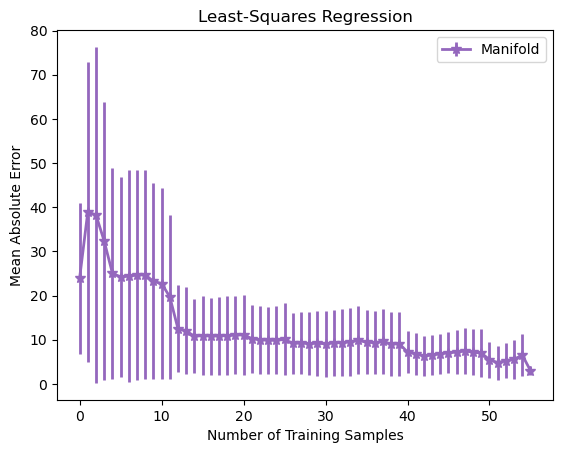

In [7]:
# okay NOW let's look at all of the errors

all_lsq_mae = []
all_lsq_std = []
for ii,epoch in enumerate(all_lle):
    # first let's do total errors
    totals = [sum(lle)/len(lle) for lle in epoch]
    all_lsq_std.append(np.std(totals))
    all_lsq_mae.append(np.mean(totals))


plt.errorbar(np.arange(len(all_lle)),all_lsq_mae,yerr=all_lsq_std,marker='*',c='tab:purple',linewidth=2,markersize=7,label='Manifold')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Number of Training Samples')
plt.title('Least-Squares Regression')
plt.legend()

plt.savefig('figures/lsq_regression_error.png')
    